<a href="https://colab.research.google.com/github/rthomps5/SC-QAM-Nonlinear-Distortion-Modeling/blob/main/Equalization_of_Severe_Nonlinear_Distortion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

QAM Constellation data viewing will require these imports and versions

In [1]:
import numpy as np
import matplotlib as mat
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
print("numpy ver", np.__version__)  # should be 1.21.5+
print("matplotlib ver", mat.__version__)  # should be 3.2.2+
print("tensorflow ver", tf.__version__)  # should be 2.8.0+
print("pandas ver", pd.__version__)  # should be 1.3.5+

numpy ver 1.21.5
matplotlib ver 3.2.2
tensorflow ver 2.8.0
pandas ver 1.3.5


Floating point precision to 3 decimal places

In [2]:
np.set_printoptions(suppress=True, precision=3, formatter={'float': '{: 0.3f}'.format})

Symbol files include 1,024,000, nearly equally distributed symbols, sent in a specific sequence 

In [5]:
IQ = np.loadtxt('neg26dBc64QAMIQv2.txt')

Enter Adjacent Channel Leakage Ratio, in dBc, based on the data file name "neg26dBc"

In [6]:
ACLR = -26

Use non-distorted, ACLR = -50 dBc, symbol sequence, since the same symbol sequence is used for all varying nonlinear distortion sequences, and will represent the ideal constellation point for each receive symbol

In [7]:
SYM = np.loadtxt('neg50dBc64QAMSYMv2.txt')

Must set "QAM" constellation size, 4 = QPSK, 16 = 16-QAM, or 64 = 64-QAM

In [8]:
QAM = 64
if QAM == 4:
    qpss = np.array([1+1j, -1+1j, 1-1j, -1-1j]/np.sqrt(2))
elif QAM == 16:
    qpss = np.array([3+3j, 1+3j, -1+3j, -3+3j,   3+1j, 1+1j, -1+1j, -3+1j, 
                     3-1j, 1-1j, -1-1j, -3-1j,   3-3j, 1-3j, -1-3j, -3-3j]/np.sqrt(9))
elif QAM == 64:
    qpss = np.array([7 + 7j, 5 + 7j, 3 + 7j, 1 + 7j, -1 + 7j, -3 + 7j, -5 + 7j, -7 + 7j,
                     7 + 5j, 5 + 5j, 3 + 5j, 1 + 5j, -1 + 5j, -3 + 5j, -5 + 5j, -7 + 5j,
                     7 + 3j, 5 + 3j, 3 + 3j, 1 + 3j, -1 + 3j, -3 + 3j, -5 + 3j, -7 + 3j,
                     7 + 1j, 5 + 1j, 3 + 1j, 1 + 1j, -1 + 1j, -3 + 1j, -5 + 1j, -7 + 1j,
                     7 - 1j, 5 - 1j, 3 - 1j, 1 - 1j, -1 - 1j, -3 - 1j, -5 - 1j, -7 - 1j,
                     7 - 3j, 5 - 3j, 3 - 3j, 1 - 3j, -1 - 3j, -3 - 3j, -5 - 3j, -7 - 3j,
                     7 - 5j, 5 - 5j, 3 - 5j, 1 - 5j, -1 - 5j, -3 - 5j, -5 - 5j, -7 - 5j,
                     7 - 7j, 5 - 7j, 3 - 7j, 1 - 7j, -1 - 7j, -3 - 7j, -5 - 7j, -7 - 7j]/np.sqrt(98))

Create two complex data arrays for each symbol, zm = complex received symbols, qm for the corresponding ideal symbol.  Full data set, for each measurement, is 1,024,000 symbols, restrict to 5,000 symbols.

In [9]:
N = 5000 #len(SYM)
zm = np.zeros((N), dtype=complex)
qm = np.zeros((N), dtype=complex)
for i in range(N):
  zm[i] = complex(IQ[i+5000,0],IQ[i+5000,1])
  qm[i] = qpss[int(SYM[i+5000])]

Plot ideal 64-QAM constellation

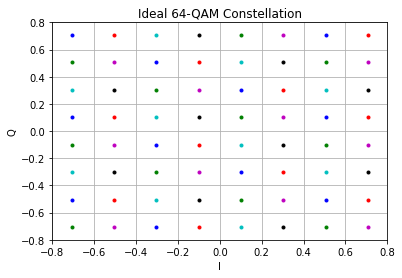

In [10]:
c='rbmgkc'
plt.grid()
plt.title('Ideal 64-QAM Constellation')
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
for k in range(len(qpss)):
  plt.plot(qpss[k].real, qpss[k].imag, c[np.mod(k,6)]+'.')

Plot 5,000 symbol constellation with severe nonlinearity

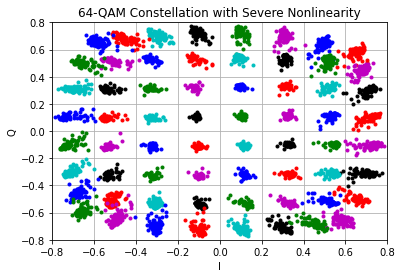

In [11]:
plt.title('64-QAM Constellation with Severe Nonlinearity')
plt.grid()
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
for k in range(len(qpss)):
  i = np.where(qm[0:N]==qpss[k])[0]
  plt.plot(zm[i].real, zm[i].imag, c[np.mod(k,6)]+'.')

Construct training & testing data for the NN equalizer


In [12]:
Ke = 60 #30-10#-4  # number of nonlinear equalizer coefficients
Ke1 = 10 # 6-2  # number of nonlinear items
Ke2 = int(Ke/Ke1)  # number of delays
M = zm.shape[0] # total input data
Be = np.zeros((M-Ke2, Ke), dtype=complex)
for i in range(Ke2):
    for k in range(Ke1):
        Be[:, Ke1 * i + k] = zm[i:M - Ke2 + i] * (np.power((zm[i:M - Ke2 + i]), k))
dd = 0 # equalization delay
if 1:
    Xd = np.zeros((M-Ke2, 2*Ke, 1), dtype=float)
    Xd[:, 0:2*Ke:2, 0] = Be.real
    Xd[:, 1:2*Ke:2, 0] = Be.imag
    Yd = np.zeros((M-Ke2, 2), dtype=float)
    if dd < 0:
        Yd = np.zeros((M-Ke2, 2), dtype=float)
        Yd[-dd:, 0] = qm[:M-Ke2+dd].real
        Yd[-dd:, 1] = qm[:M-Ke2+dd].imag
    else:
        Yd[:, 0] = qm[dd:M-Ke2+dd].real
        Yd[:, 1] = qm[dd:M-Ke2+dd].imag
else:
    Xd = np.zeros((M - Ke2, Ke, 2), dtype=float)
    Xd[:, :, 0] = Be.real
    Xd[:, :, 1] = Be.imag
    Yd = np.zeros((M - Ke2, 2), dtype=float)
    Yd[:, 0] = qm[dd:M - Ke2 + dd].real
    Yd[:, 1] = qm[dd:M - Ke2 + dd].imag

TL = int(np.ceil(M*0.75-Ke+1))
Xtrain = Xd[0:TL, :]
Ytrain = Yd[0:TL, :]
Xtest = Xd[TL:, :]
Ytest = Yd[TL:, :]

Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape

((3691, 120, 1), (3691, 2), (1303, 120, 1), (1303, 2))

NN Model

In [13]:
tf.compat.v1.disable_eager_execution()
Xt = tf.compat.v1.placeholder(tf.float32, [None]+list(Xtrain.shape[1:]))
Yt = tf.compat.v1.placeholder(tf.float32, [None, 2])
dp = tf.compat.v1.placeholder(tf.float32, [1])
if True:
    yn3 = tf.compat.v1.layers.conv1d(Xt, filters=20, kernel_size=30, strides=1, padding='same',
                          activation=tf.nn.tanh)
    yn3 = tf.compat.v1.layers.flatten(yn3)
    yn3 = tf.compat.v1.layers.dropout(yn3, rate=dp)
    yn3 = tf.compat.v1.layers.dense(yn3, 20, activation=tf.nn.tanh)
    yn3 = tf.compat.v1.layers.dense(yn3, 20, activation=tf.nn.tanh)
    yn3 = tf.compat.v1.layers.dense(yn3, 20, activation=tf.nn.tanh)
    logits = tf.compat.v1.layers.dense(yn3, 2, activation=None)
else:
    yn = tf.compat.v1.layers.dense(tf.layers.flatten(Xt), 10, activation=tf.nn.tanh)
    yn2 = tf.compat.v1.layers.dense(yn, 10, activation=tf.nn.tanh)
    yn3 = tf.compat.v1.layers.dense(yn2, 20, activation=tf.nn.tanh)
    yn4 = tf.compat.v1.layers.dense(yn3, 10, activation=tf.nn.tanh)
    logits = tf.compat.v1.layers.dense(yn4, 2, activation=None)
loss = tf.reduce_mean(tf.compat.v1.losses.mean_squared_error(labels=Yt, predictions=logits))
mytrain = tf.compat.v1.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

sess = tf.compat.v1.Session()
sess.run(tf.compat.v1.global_variables_initializer())
# 10, 256, 0.5, --> 0.11
# 20, 256, 0.25 --> 0.115
# 20, 16, 0.1 --> 0.09 (32000)

# no noise: 20/10+0.5dp+20 mse/ser:0.08/0.01 32/5M tanh/none

# no noise z(n)^k: 20/20/20+0.5dp+20 mse/ser:.0266/.00395 tanh/none (24/4)
# 30dB:                                      .0934/.0257            (24/4)
# 30dB:                     dp=0             .0587/.0119
#                        +kernel 30          .0487/.0079
#                  20+dense20/20/20          .0454/.0089
#                     +.8dp                  .0466/.0049 (.039/.0029)
# 30dB: z(n)^k: 20/20/20+0.5dp+20 mse/ser:0.07/0.02 32/5M tanh/none

# noiseless(10,10,20,10) mse/ser: (same30/6) .043/.00197 matlab  .027/.00098 python  .0098/0 (20/4)
# 30dB SNR                   .147/.035(30/6) .061/.00592 matlab  .045/.00587 python  .054/.0119(20/4)
# 30dB z(n)^k:                                                               python  .070/.0138(20/4)

# train NN model
step = 0
batch_size = 32
training_iter = 5000000
shf = np.arange(len(Xtrain))
msea = np.zeros((1000,2), dtype=float)
msei = 0
bat1 = 0
while step*batch_size < training_iter:
    if bat1 > TL-batch_size:
        bat2 = shf[TL-batch_size:TL]
        np.random.shuffle(shf)
        bat1 = 0
    else: bat2 = shf[bat1:bat1+batch_size]
    sess.run(mytrain, feed_dict={Xt:Xtrain[bat2], Yt:Ytrain[bat2], dp:[0.8]})
    if (step*batch_size) % int(training_iter/200) == 0:
        mse = sess.run(loss, feed_dict={Xt:Xtrain[bat2], Yt:Ytrain[bat2], dp:[0.8]})
        msea[msei, 0] = sess.run(loss, feed_dict={Xt:Xtrain, Yt:Ytrain, dp:[0.]})
        msea[msei, 1] = sess.run(loss, feed_dict={Xt:Xtest, Yt:Ytest, dp:[0.]})
        print("Iter %d: mse= %.5f. train= %.5f. Test= %.5f" %(step*batch_size,
                    mse, msea[msei,0], msea[msei, 1]))
        msei = msei + 1
   # if mse < .00001: break
    step = step + 1
    bat1 = bat1 + batch_size
print("optimization finished!")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `tf.layers.conv1d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv1D` instead.
  import sys
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:294: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:541: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: `tf.layers.dropout` is deprecated and will b

Iter 0: mse= 0.17790. train= 0.21602. Test= 0.21109
Iter 100000: mse= 0.00122. train= 0.00134. Test= 0.00155
Iter 200000: mse= 0.00097. train= 0.00143. Test= 0.00176
Iter 300000: mse= 0.00097. train= 0.00107. Test= 0.00144
Iter 400000: mse= 0.00089. train= 0.00087. Test= 0.00126
Iter 500000: mse= 0.00089. train= 0.00074. Test= 0.00116
Iter 600000: mse= 0.00080. train= 0.00070. Test= 0.00116
Iter 700000: mse= 0.00055. train= 0.00094. Test= 0.00142
Iter 800000: mse= 0.00081. train= 0.00075. Test= 0.00124
Iter 900000: mse= 0.00055. train= 0.00064. Test= 0.00115
Iter 1000000: mse= 0.00045. train= 0.00053. Test= 0.00111
Iter 1100000: mse= 0.00048. train= 0.00049. Test= 0.00111
Iter 1200000: mse= 0.00054. train= 0.00060. Test= 0.00126
Iter 1300000: mse= 0.00049. train= 0.00044. Test= 0.00112
Iter 1400000: mse= 0.00053. train= 0.00051. Test= 0.00121
Iter 1500000: mse= 0.00053. train= 0.00045. Test= 0.00114
Iter 1600000: mse= 0.00052. train= 0.00051. Test= 0.00114
Iter 1700000: mse= 0.00044. t

Test NN model

In [14]:
mse, z = sess.run([loss, logits], feed_dict={Xt:Xtrain, Yt:Ytrain, dp:[0.]})
Ztrain = z[:, 0] + 1j * z[:, 1]
BER1 = np.mean((np.argmin(np.abs(Ztrain.reshape(-1,1)-qpss.reshape(1,-1)),axis=1)!=\
    np.argmin(np.abs(qm[dd:TL+dd].reshape(-1,1)-qpss.reshape(1,-1)),axis=1)).astype(float))
MSE, z = sess.run([loss, logits], feed_dict={Xt:Xtest, Yt:Ytest, dp:[0.]})
Ztest = z[:, 0] + 1j * z[:, 1]
BER2 = np.mean((np.argmin(np.abs(Ztest.reshape(-1,1)-qpss.reshape(1,-1)),axis=1)!=\
    np.argmin(np.abs(qm[TL+dd:M-Ke2+dd].reshape(-1,1)-qpss.reshape(1,-1)),axis=1)).astype(float))
print("Train RMSE = %.5f, Testing RMSE = %.5f. Train SER= %.5f, Testing SER= %.5f"
      %(np.sqrt(mse), np.sqrt(MSE), BER1, BER2))

Train RMSE = 0.00657, Testing RMSE = 0.03122. Train SER= 0.00000, Testing SER= 0.04451


Plot distorted constellation

Text(0.5, 1.0, 'RX:Measured ACLR = -26dBc')

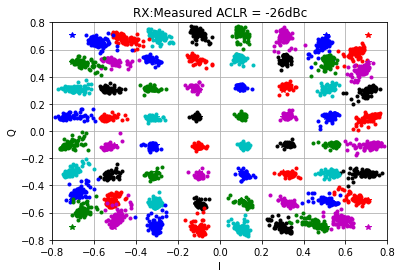

In [24]:
plt.grid()
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
for k in range(len(qpss)):
    plt.plot(qpss[k].real, qpss[k].imag, c[np.mod(k,6)]+'*')
    i = np.where(qm[0:N-2]==qpss[k])[0]
    plt.plot(zm[i].real, zm[i].imag, c[np.mod(k,6)]+'.')
plt.title('RX:Measured ACLR = ' +str(int(ACLR))+'dBc')


Plot NN trained constellation

Text(0.5, 1.0, 'New Volterra NN Train')

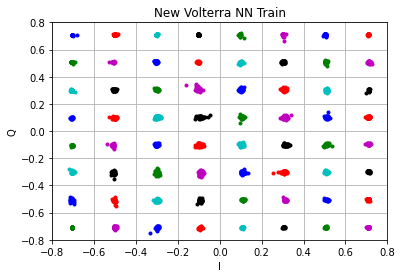

In [23]:
for k in range(len(qpss)):
    i = np.where(qm[dd:TL+dd]==qpss[k])[0]
    plt.plot(Ztrain[i].real, Ztrain[i].imag, c[np.mod(k,6)]+'.')
plt.grid()
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
plt.title('New Volterra NN Train')

Plot the accuracy curves for the train and test sets

Text(0.5, 0, 'Iterations')

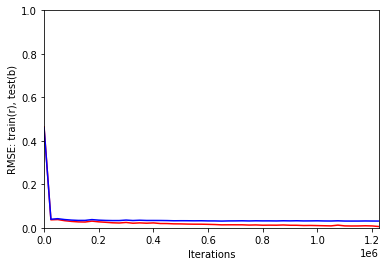

In [17]:
plt.plot(np.arange(0,msei)*int(training_iter/200), np.sqrt(msea[:msei,0]), 'r-')
plt.plot(np.arange(0,msei)*int(training_iter/200), np.sqrt(msea[:msei,1]), 'b-')
plt.axis([0, (msei-1)*int(training_iter/200), 0, 1])
plt.ylabel('RMSE: train(r), test(b)')
#plt.legend('Train RMSE', 'Test RMSE')
plt.xlabel('Iterations')

Plot NN test constellation

Text(0.5, 1.0, 'New Volterra NN Pred')

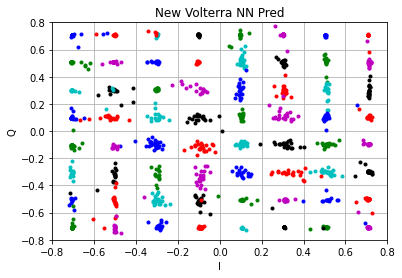

In [22]:
for k in range(len(qpss)):
    i = np.where(qm[TL+dd:M-Ke2+dd]==qpss[k])[0]
    plt.plot(Ztest[i].real, Ztest[i].imag, c[np.mod(k,6)]+'.')
plt.grid()
plt.ylabel('Q')
plt.xlabel('I')
plt.axis([-0.8, 0.8, -0.8, 0.8])
plt.title('New Volterra NN Pred')